## Importing Libraries

In [86]:
import pandas as pd 
import sqlalchemy as sa
import matplotlib.pyplot as plt
import plotly as pt
import seaborn as sns
import matplotlib.dates as mdates
import os
import numpy as np
import streamlit as st

## Importing the reference data (Practice populations)

In [43]:
#connect to your server and specify the reference table   
server = r'BIS-000-SP05.bis.xswhealth.nhs.uk, 14431'
database = 'Reference'

# The following constructs a connection string understood by SQL Server. It 
# adds in the server and database specified above.
# driver version 
connection_string = ('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+
                     ';DATABASE='+database+
                     ';ENCRYPT=no;TRUSTED_CONNECTION=yes;'
    )

# the connection_url combines the the connection string with the driver and
# the sql dialect
connection_url = sa.engine.URL.create(
    "mssql+pyodbc", # sqlalchemy blends the dialect of SQL with the pyodbc driver 
    query=dict(odbc_connect=connection_string)
    )

# sqlalchemy builds a connection engine from the connection_url.
# fast_executemany = True speeds up the query.
engine = sa.create_engine(connection_url, fast_executemany= True) 

# enter the SQl query here in an f-string. The backslashes act both as line-break
# characters and escape characters for the apostrophes.
query = """DECLARE @MaxDate DATE=(SELECT MAX(PublicationDate) FROM [PrimaryCare_Public].[dbo].[GP_Registered_Patients])
          SELECT SUM([Number_Of_Patients]) [Population], LEFT(Reef_CCG_Name, CHARINDEX(' -', Reef_CCG_Name) - 1) ICB_Name
          ,CCG_Code [ICB_Code]
          FROM [PrimaryCare_Public].[dbo].[GP_Registered_Patients]
          WHERE PublicationDate = @MaxDate
          AND Sex = 'All'
          AND Age = 'All'
          GROUP BY LEFT(Reef_CCG_Name, CHARINDEX(' -', Reef_CCG_Name) - 1),ccg_code
          ORDER BY SUM([Number_Of_Patients]) DESC"""
#From here you can add multiple queries if they are on the same server and in the same database
#query2 = """ """

# import the data into a pandas dataframe using the .read_sql() method,
# which takes the SQL query and the connection engine as arguments.
ref_df = pd.read_sql(query, engine)
#An example of bringing through query2
#ref_df2 = pd.read_sql(query2, engine)


## Looking at the first 5 rows of the dataframe

In [4]:
#Brings up the first 5 rows of the dataframe you have loaded. Python uses zero indexing, their rows, columns and strings all start at 0!
#Make sure you define a variable to put the dataframe in (in this case, df) so you can call upon it whenever you want to query it.
ref_df.head()

,Population,ICB_Name,ICB_Code
0,2921090,NHS NORTH WEST LONDON ICB,W2U3Z
1,2483937,NHS NORTH EAST LONDON ICB,A3A8R
2,2124282,NHS SOUTH EAST LONDON ICB,72Q
3,2041764,NHS KENT AND MEDWAY ICB,91Q
4,1835876,NHS NORTH CENTRAL LONDON ICB,93C


## Deleting an existing csv in the project folder
(This is so that data is not added to an existing .csv while this code is being re-run)

In [ ]:
file_path = "./Data/all_data.csv"

# Check if file exists before deleting
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"{file_path} has been deleted.")
else:
    print("File not found.")

./Data/all_data.csv has been deleted.


## Reading a csv in the project folder and merging with other files into a .csv output


In [6]:
#read_csv is a pandas function to bring through a CSV. 
df = pd.read_csv("./Data/Regional_CSV_BucksOxonBerksW.csv")

#The following code is a way to join multiple files together. I learned this on YouTube!
#Files = the collection of files in /Data. file is defined as each csv file in /Data folder. 
files = [file for file in os.listdir('./Data')]
#Creates an empty dataframe called all_files_months_data to put the files in
all_months_data = pd.DataFrame()
#for loop. For every file found in /Data folder, read csv, and add a new file. All_months_data is defined as concatenating all the files, and adding 
#the orignial df which has already been brought though at the top (BucksOxonBerksW)
for file in files:
    df = pd.read_csv("./Data/"+file)
    all_months_data = pd.concat([all_months_data, df])
    
#We are now using to_csv functiojn on ouyr all_months_data variable to put all of the concatenated data into a new CV. Index=false means that we 
#don't want a new index column added to this file.
all_months_data.to_csv('./Data/all_data.csv', index=False)

df = pd.read_csv("./Data/all_data.csv")
df.head()

,SUB_ICB_LOCATION_CODE,SUB_ICB_LOCATION_ONS_CODE,SUB_ICB_LOCATION_NAME,ICB_ONS_CODE,ICB_NAME,REGION_ONS_CODE,REGION_NAME,APPOINTMENT_MONTH,APPT_STATUS,HCP_TYPE,APPT_MODE,TIME_BETWEEN_BOOK_AND_APPT,COUNT_OF_APPOINTMENTS
0,10Q,E38000136,NHS Buckinghamshire Oxfordshire and Berkshire ...,E54000044,"NHS Buckinghamshire, Oxfordshire and Berkshire...",E40000005,South East,JAN2023,Attended,GP,Face-to-Face,1 Day,7038
1,10Q,E38000136,NHS Buckinghamshire Oxfordshire and Berkshire ...,E54000044,"NHS Buckinghamshire, Oxfordshire and Berkshire...",E40000005,South East,JAN2023,Attended,GP,Face-to-Face,15 to 21 Days,3875
2,10Q,E38000136,NHS Buckinghamshire Oxfordshire and Berkshire ...,E54000044,"NHS Buckinghamshire, Oxfordshire and Berkshire...",E40000005,South East,JAN2023,Attended,GP,Face-to-Face,2 to 7 Days,17580
3,10Q,E38000136,NHS Buckinghamshire Oxfordshire and Berkshire ...,E54000044,"NHS Buckinghamshire, Oxfordshire and Berkshire...",E40000005,South East,JAN2023,Attended,GP,Face-to-Face,22 to 28 Days,2608
4,10Q,E38000136,NHS Buckinghamshire Oxfordshire and Berkshire ...,E54000044,"NHS Buckinghamshire, Oxfordshire and Berkshire...",E40000005,South East,JAN2023,Attended,GP,Face-to-Face,8 to 14 Days,8813


## Data overview using:
.info() \
.describe() \
.shape

In [ ]:
#df.info is good to see how many rows and columns there are, and how many nulls are in the columns. We can also see the datatype.
#We want the APPOINTMENT_MONTH column to have a datatype datetime so our chart library recognises it as a date.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627579 entries, 0 to 627578
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   SUB_ICB_LOCATION_CODE       627579 non-null  object        
 1   SUB_ICB_LOCATION_ONS_CODE   627579 non-null  object        
 2   SUB_ICB_LOCATION_NAME       627579 non-null  object        
 3   ICB_ONS_CODE                627579 non-null  object        
 4   ICB_NAME                    627579 non-null  object        
 5   REGION_ONS_CODE             627579 non-null  object        
 6   REGION_NAME                 627579 non-null  object        
 7   APPOINTMENT_MONTH           627579 non-null  object        
 8   APPT_STATUS                 627579 non-null  object        
 9   HCP_TYPE                    627579 non-null  object        
 10  APPT_MODE                   627579 non-null  object        
 11  TIME_BETWEEN_BOOK_AND_APPT  627579 non-

In [50]:
df.describe()

,COUNT_OF_APPOINTMENTS,DATE
count,627579.000000,627579
mean,1482.414909,2024-03-25 14:37:13.485824256
min,1.000000,2023-01-01 00:00:00
25%,8.000000,2023-09-01 00:00:00
50%,61.000000,2024-04-01 00:00:00
75%,423.000000,2024-11-01 00:00:00
max,109191.000000,2025-06-01 00:00:00
std,5895.578790,NaN


In [51]:
df.shape

(627579, 15)

## Dealing with NAs

## Parsing the date
dateutil is a useful package for changing weird dates to a recognisable datetime format. (you do not need to install this via PowerShell)\
info here: 'https://dateutil.readthedocs.io/en/stable/'.\
\
df.['DATE'] - here I am calling on my df variable (the dataframe) and creating a column called DATE. You can also call upon columns that already \ exist. After the = sign, I am calling upon the column APPOINTMENT_MONTH, where we have a funny date (JAN2023) and I am using the apply function.\
Within the parenthesis, I can then add various libraries to apply to the column. I have used parser.parse. This library is very good \
at recognising a string date and turning it into a datetime format.


In [52]:
#dateutil is a useful package for changing weird dates to a recognisable datetime format. (you do not need to install this via PowerShell)
# info here: https://dateutil.readthedocs.io/en/stable/
from dateutil import parser
#df.['DATE'] - here I am calling on my df variable (the dataframe) and creating a column called DATE. You can also call upon columns that already
#exist. After the = sign, I am calling upon the column APPOINTMENT_MONTH, where we have a funny date (JAN2023) and I am using the apply function.
#Within the parenthesis, I can then add various libraries to apply to the column. IN this case, I have used parser.parse. This library is very good
#at recognising a string date and turning it into a datetime format.
df['DATE'] = df['APPOINTMENT_MONTH'].apply(parser.parse)
#The date came back as the 18th January 2023. This is because I did this on the 18th! I would like to set it to the 1st of the month. I have used 
#the timestamp function, with 'M' as month. dt = datetime
df['DATE'] = df['DATE'].dt.to_period('M').dt.to_timestamp()

Month = df['APPOINTMENT_MONTH'].str[0:3]
Year = df['APPOINTMENT_MONTH'].str[5:7]
df['MMM-YY'] = Month + '-' + Year


df.head()

,SUB_ICB_LOCATION_CODE,SUB_ICB_LOCATION_ONS_CODE,SUB_ICB_LOCATION_NAME,ICB_ONS_CODE,ICB_NAME,REGION_ONS_CODE,REGION_NAME,APPOINTMENT_MONTH,APPT_STATUS,HCP_TYPE,APPT_MODE,TIME_BETWEEN_BOOK_AND_APPT,COUNT_OF_APPOINTMENTS,DATE,MMM-YY
0,10Q,E38000136,NHS Buckinghamshire Oxfordshire and Berkshire ...,E54000044,"NHS Buckinghamshire, Oxfordshire and Berkshire...",E40000005,South East,JAN2023,Attended,GP,Face-to-Face,1 Day,7038,2023-01-01,JAN-23
1,10Q,E38000136,NHS Buckinghamshire Oxfordshire and Berkshire ...,E54000044,"NHS Buckinghamshire, Oxfordshire and Berkshire...",E40000005,South East,JAN2023,Attended,GP,Face-to-Face,15 to 21 Days,3875,2023-01-01,JAN-23
2,10Q,E38000136,NHS Buckinghamshire Oxfordshire and Berkshire ...,E54000044,"NHS Buckinghamshire, Oxfordshire and Berkshire...",E40000005,South East,JAN2023,Attended,GP,Face-to-Face,2 to 7 Days,17580,2023-01-01,JAN-23
3,10Q,E38000136,NHS Buckinghamshire Oxfordshire and Berkshire ...,E54000044,"NHS Buckinghamshire, Oxfordshire and Berkshire...",E40000005,South East,JAN2023,Attended,GP,Face-to-Face,22 to 28 Days,2608,2023-01-01,JAN-23
4,10Q,E38000136,NHS Buckinghamshire Oxfordshire and Berkshire ...,E54000044,"NHS Buckinghamshire, Oxfordshire and Berkshire...",E40000005,South East,JAN2023,Attended,GP,Face-to-Face,8 to 14 Days,8813,2023-01-01,JAN-23


## Selecting and dropping a series (column)

Note:\
Single square brackets [] are used for selecting a single column, which returns a Series.\
Double square brackets [[]] are used for selecting multiple columns, which returns a DataFrame.\

In [53]:
gp_apps = df.copy()

gp_apps = gp_apps[['SUB_ICB_LOCATION_CODE','HCP_TYPE','TIME_BETWEEN_BOOK_AND_APPT','COUNT_OF_APPOINTMENTS','APPT_STATUS','DATE','MMM-YY']]

#df.drop(columns=['col1', 'col2'], inplace=True)

gp_apps.head()

,SUB_ICB_LOCATION_CODE,HCP_TYPE,TIME_BETWEEN_BOOK_AND_APPT,COUNT_OF_APPOINTMENTS,APPT_STATUS,DATE,MMM-YY
0,10Q,GP,1 Day,7038,Attended,2023-01-01,JAN-23
1,10Q,GP,15 to 21 Days,3875,Attended,2023-01-01,JAN-23
2,10Q,GP,2 to 7 Days,17580,Attended,2023-01-01,JAN-23
3,10Q,GP,22 to 28 Days,2608,Attended,2023-01-01,JAN-23
4,10Q,GP,8 to 14 Days,8813,Attended,2023-01-01,JAN-23


#### Replacing strings
#### Merging dataframes
#### Calculating rate using two series
#### Creating a Boolean Mask to filter

In [ ]:
gp_pop = gp_apps.copy()

gp_pop['TIME_BETWEEN_BOOK_AND_APPT'] = gp_pop['TIME_BETWEEN_BOOK_AND_APPT'].str.replace('  ', ' ')
gp_pop = pd.merge(gp_pop, ref_df, left_on='SUB_ICB_LOCATION_CODE', right_on='ICB_Code', how='left').drop(['ICB_Name'], axis=1)
gp_pop['RATE'] = round(((gp_pop['COUNT_OF_APPOINTMENTS'] / gp_pop['Population']) * 1000),5)
gp_mask = gp_pop['TIME_BETWEEN_BOOK_AND_APPT'] .isin(['Unknown / Data Quality'])
gp_pop = gp_pop[~gp_mask]
gp_pop.head()

,SUB_ICB_LOCATION_CODE,HCP_TYPE,TIME_BETWEEN_BOOK_AND_APPT,COUNT_OF_APPOINTMENTS,APPT_STATUS,DATE,MMM-YY,Population,ICB_Code,RATE
0,10Q,GP,1 Day,7038,Attended,2023-01-01,JAN-23,827923,10Q,8.50079
1,10Q,GP,15 to 21 Days,3875,Attended,2023-01-01,JAN-23,827923,10Q,4.68039
2,10Q,GP,2 to 7 Days,17580,Attended,2023-01-01,JAN-23,827923,10Q,21.23386
3,10Q,GP,22 to 28 Days,2608,Attended,2023-01-01,JAN-23,827923,10Q,3.15005
4,10Q,GP,8 to 14 Days,8813,Attended,2023-01-01,JAN-23,827923,10Q,10.64471


## Checking for sucessful merge

In [77]:
unique_df = gp_pop.copy()

unique_df = unique_df[['ICB_Code','SUB_ICB_LOCATION_CODE']]
unique_df.drop_duplicates()

# unique_df1 = pd.unique(gp_pop['SUB_ICB_LOCATION_CODE'])
# unique_df2 = pd.unique(gp_pop['ICB_Code'])

,ICB_Code,SUB_ICB_LOCATION_CODE
0,10Q,10Q
6673,14Y,14Y
13770,15A,15A
21108,D4U1Y,D4U1Y
27343,10R,10R
32559,D9Y0V,D9Y0V
41275,11X,11X
48637,09D,09D
55454,70F,70F
63024,97R,97R


## Boolean Mask to filter data

In [80]:
#1st way (methodical)
# dna_mask = gp_apps['APPT_STATUS'] == 'DNA'  

# dna_df = gp_apps[dna_mask]
# dna_df.head()

#2nd way (streamlined)
dna_df = gp_apps[gp_apps['APPT_STATUS'] == 'Attended']

dna_df.head()

,SUB_ICB_LOCATION_CODE,HCP_TYPE,TIME_BETWEEN_BOOK_AND_APPT,COUNT_OF_APPOINTMENTS,APPT_STATUS,DATE,MMM-YY
0,10Q,GP,1 Day,7038,Attended,2023-01-01,JAN-23
1,10Q,GP,15 to 21 Days,3875,Attended,2023-01-01,JAN-23
2,10Q,GP,2 to 7 Days,17580,Attended,2023-01-01,JAN-23
3,10Q,GP,22 to 28 Days,2608,Attended,2023-01-01,JAN-23
4,10Q,GP,8 to 14 Days,8813,Attended,2023-01-01,JAN-23


## Defining a function with an if loop

In [57]:
gp_pop2 = gp_pop.copy()

def icb_map(row):
    if row['ICB_Code'] in ['10Q','14Y','15A']:
        value = 'BOB ICB'
    elif row['ICB_Code'] == 'D4U1Y':
        value = 'Frimley ICB'
    elif row['ICB_Code'] in ['09D','70F','97R']:
        value = 'Sussex ICB'
    elif row['ICB_Code'] == '11X':
        value = 'Somerset ICB'
    else:
        value = 'HIOW ICB'
    return value

gp_pop2['ICB_NAME'] = gp_pop.apply(icb_map, axis = 1)
gp_pop2.head()

,SUB_ICB_LOCATION_CODE,HCP_TYPE,TIME_BETWEEN_BOOK_AND_APPT,COUNT_OF_APPOINTMENTS,APPT_STATUS,DATE,MMM-YY,Population,ICB_Code,RATE,ICB_NAME
0,10Q,GP,1 Day,7038,Attended,2023-01-01,JAN-23,827923,10Q,8.50079,BOB ICB
1,10Q,GP,15 to 21 Days,3875,Attended,2023-01-01,JAN-23,827923,10Q,4.68039,BOB ICB
2,10Q,GP,2 to 7 Days,17580,Attended,2023-01-01,JAN-23,827923,10Q,21.23386,BOB ICB
3,10Q,GP,22 to 28 Days,2608,Attended,2023-01-01,JAN-23,827923,10Q,3.15005,BOB ICB
4,10Q,GP,8 to 14 Days,8813,Attended,2023-01-01,JAN-23,827923,10Q,10.64471,BOB ICB


In [ ]:

gp_pop3 = gp_pop2.copy()
def sort_order(row):
    if row['TIME_BETWEEN_BOOK_AND_APPT'] == 'Same Day':
        value = 1
    elif row['TIME_BETWEEN_BOOK_AND_APPT'] == '1 Day':
        value = 2
    elif row['TIME_BETWEEN_BOOK_AND_APPT'] == '2 to 7 Days':
        value = 3
    elif row['TIME_BETWEEN_BOOK_AND_APPT'] == '8 to 14 Days':
        value = 4
    elif row['TIME_BETWEEN_BOOK_AND_APPT'] == '15 to 21 Days':
        value = 5
    elif row['TIME_BETWEEN_BOOK_AND_APPT'] == '22 to 28 Days':
        value = 6
    elif row['TIME_BETWEEN_BOOK_AND_APPT'] == 'More than 28 Days':
        value = 7
    else:
        value = 'NULL'
    return value
   #axis = 1 means apply function by row. axis=0 means apply function by column.
gp_pop3['SORT_ORDER'] = gp_pop.apply(sort_order, axis = 1)
gp_pop3.head()



,SUB_ICB_LOCATION_CODE,HCP_TYPE,TIME_BETWEEN_BOOK_AND_APPT,COUNT_OF_APPOINTMENTS,APPT_STATUS,DATE,MMM-YY,Population,ICB_Code,RATE,ICB_NAME,SORT_ORDER
0,10Q,GP,1 Day,7038,Attended,2023-01-01,JAN-23,827923,10Q,8.50079,BOB ICB,2
1,10Q,GP,15 to 21 Days,3875,Attended,2023-01-01,JAN-23,827923,10Q,4.68039,BOB ICB,5
2,10Q,GP,2 to 7 Days,17580,Attended,2023-01-01,JAN-23,827923,10Q,21.23386,BOB ICB,3
3,10Q,GP,22 to 28 Days,2608,Attended,2023-01-01,JAN-23,827923,10Q,3.15005,BOB ICB,6
4,10Q,GP,8 to 14 Days,8813,Attended,2023-01-01,JAN-23,827923,10Q,10.64471,BOB ICB,4


In [59]:
time_periods = gp_pop3['TIME_BETWEEN_BOOK_AND_APPT'].unique().tolist()
for i in time_periods:
    print (f'{i}: {len(i)}')


1 Day: 5
15 to 21 Days: 13
2 to 7 Days: 11
22 to 28 Days: 13
8 to 14 Days: 12
More than 28 Days: 17
Same Day: 8


In [81]:

att_mask = gp_pop3[gp_pop3['APPT_STATUS'] == 'Attended']

#att = gp_pop3[att_mask]
att.head()

,SUB_ICB_LOCATION_CODE,HCP_TYPE,TIME_BETWEEN_BOOK_AND_APPT,COUNT_OF_APPOINTMENTS,APPT_STATUS,DATE,MMM-YY,Population,ICB_Code,RATE,ICB_NAME,SORT_ORDER
0,10Q,GP,1 Day,7038,Attended,2023-01-01,JAN-23,827923,10Q,8.50079,BOB ICB,2
1,10Q,GP,15 to 21 Days,3875,Attended,2023-01-01,JAN-23,827923,10Q,4.68039,BOB ICB,5
2,10Q,GP,2 to 7 Days,17580,Attended,2023-01-01,JAN-23,827923,10Q,21.23386,BOB ICB,3
3,10Q,GP,22 to 28 Days,2608,Attended,2023-01-01,JAN-23,827923,10Q,3.15005,BOB ICB,6
4,10Q,GP,8 to 14 Days,8813,Attended,2023-01-01,JAN-23,827923,10Q,10.64471,BOB ICB,4


grouping 

In [82]:

# Group by TIME_BETWEEN_BOOK_AND_APPT and sort_order, then sum the COUNT_OF_APPOINTMENTS
att_pivoted = att.groupby(['TIME_BETWEEN_BOOK_AND_APPT', 'SORT_ORDER'])['RATE'].mean().reset_index()

# Sort the resulting DataFrame by sort_order
att_pivoted = att_pivoted.sort_values(by='SORT_ORDER')

# Optionally reset the index if you want a clean DataFrame
att_pivoted.reset_index(drop=True, inplace=True)
att_pivoted.head(10)

,TIME_BETWEEN_BOOK_AND_APPT,SORT_ORDER,RATE
0,Same Day,1,14.073895
1,1 Day,2,2.484394
2,2 to 7 Days,3,5.725373
3,8 to 14 Days,4,4.527889
4,15 to 21 Days,5,2.963880
5,22 to 28 Days,6,2.054335
6,More than 28 Days,7,2.044796


In [62]:
# Group by TIME_BETWEEN_BOOK_AND_APPT and sort_order, then sum the COUNT_OF_APPOINTMENTS
att_status_pivoted = gp_apps.groupby(['APPT_STATUS'])['COUNT_OF_APPOINTMENTS'].mean().reset_index()

# Sort the resulting DataFrame by sort_order
#att_pivoted = att_pivoted.sort_values(by='SORT_ORDER')

# Optionally reset the index if you want a clean DataFrame
att_status_pivoted.reset_index(drop=True, inplace=True)
att_status_pivoted.head(10)

,APPT_STATUS,COUNT_OF_APPOINTMENTS
0,Attended,3501.528033
1,DNA,256.085678
2,Unknown,216.284313


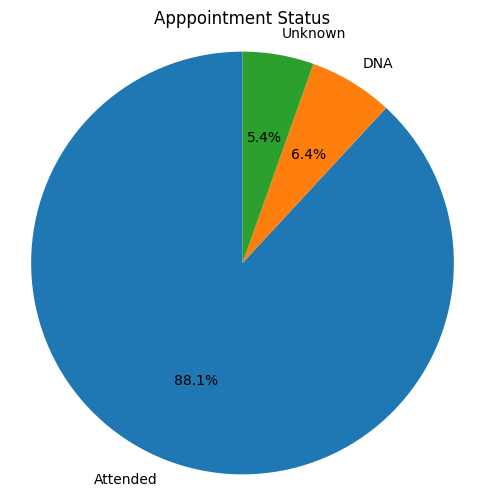

In [63]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(6, 6))
plt.pie(
    att_status_pivoted['COUNT_OF_APPOINTMENTS'],
    labels=att_status_pivoted['APPT_STATUS'],
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Apppointment Status')
plt.axis('equal')  # Equal aspect ratio makes the pie chart circular
plt.show()

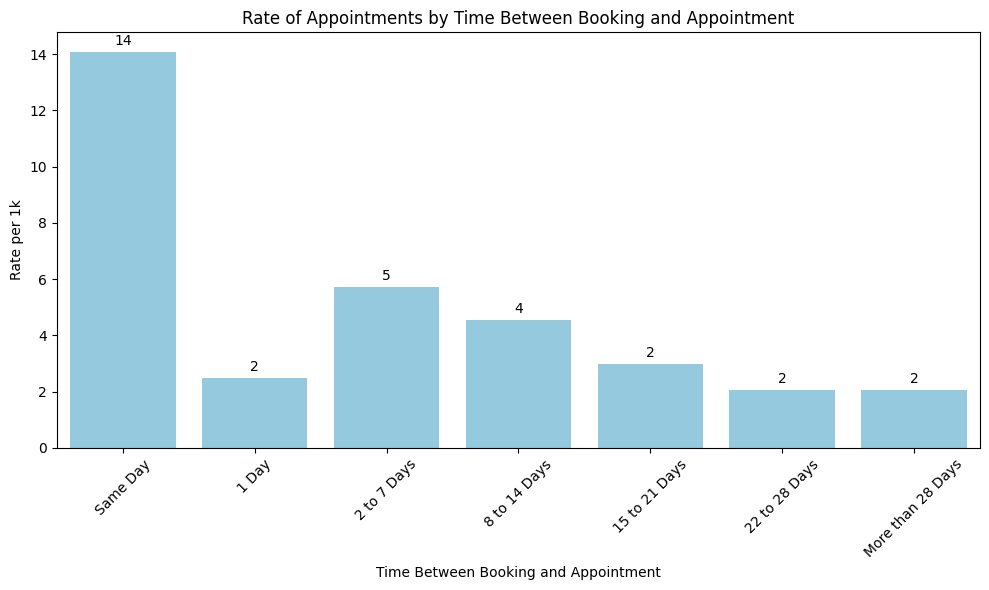

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group and sort


# Plot with seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=att_pivoted,
    x='TIME_BETWEEN_BOOK_AND_APPT',
    y='RATE',
    #order=att_pivoted['SORT_ORDER'],
    color='skyblue'
)

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.xlabel('Time Between Booking and Appointment')
plt.ylabel('Rate per 1k')
plt.title('Rate of Appointments by Time Between Booking and Appointment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [65]:
# Group by TIME_BETWEEN_BOOK_AND_APPT and sort_order, then sum the COUNT_OF_APPOINTMENTS
att_status_pivoted = gp_pop3.groupby(['DATE'])['RATE'].mean().reset_index()

# Sort the resulting DataFrame by sort_order
#att_pivoted = att_pivoted.sort_values(by='SORT_ORDER')

# Optionally reset the index if you want a clean DataFrame
att_status_pivoted.reset_index(drop=True, inplace=True)
att_status_pivoted.head()

,DATE,RATE
0,2023-01-01,2.469459
1,2023-02-01,2.323145
2,2023-03-01,2.586417
3,2023-04-01,1.835291
4,2023-05-01,2.020534


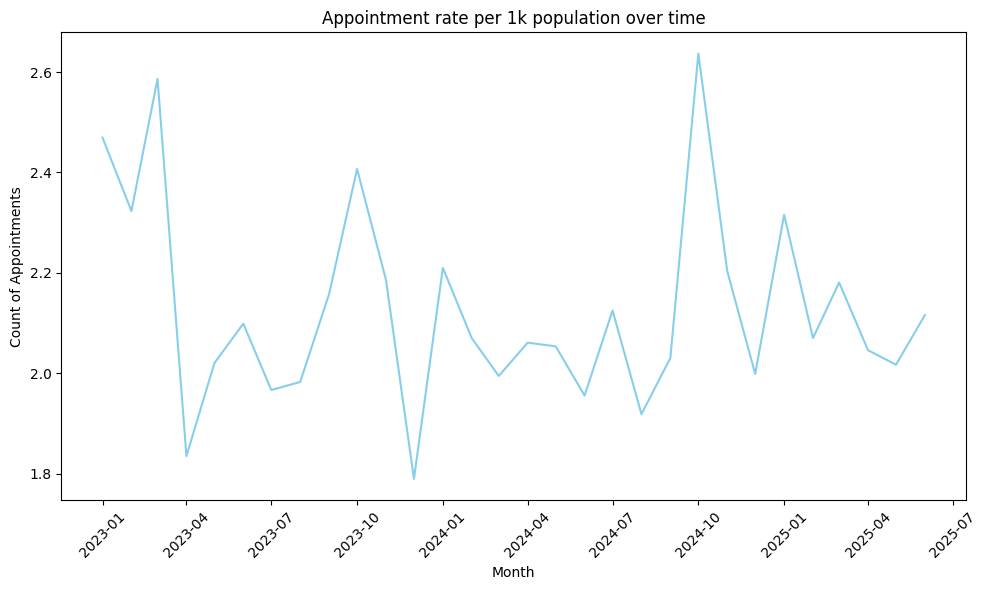

In [66]:
# Plot with seaborn
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=att_status_pivoted,
    x='DATE',
    y='RATE',
   # order=att_dt['DATE'],
    color='skyblue'
)

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.xlabel('Month')
plt.ylabel('Count of Appointments')
plt.title('Appointment rate per 1k population over time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [88]:
dropdown = st.columns(5)      

with dropdown:
            st.markdown('Unique values by column: ')
            col_select1 = st.selectbox(
                label='Select a column',
                options=set(gp_pop3['ICB_NAME']) - {'BOB ICB','FRIMLEY ICB','SURREY ICB','HIOW ICB','SUSSEX ICB'}
            )
            selected_df_val_counts = gp_pop3[col_select1]
            val_counts = selected_df_val_counts.value_counts()
            val_counts_df = val_counts.to_frame(name='Count')
            st.dataframe(val_counts_df,width=500,height=245)

2025-08-28 13:07:17.629 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-28 13:07:17.629 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-28 13:07:17.630 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-28 13:07:17.630 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-28 13:07:17.631 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-28 13:07:17.631 WARNING streamlit.run

TypeError: 'list' object does not support the context manager protocol